# Invoke Bedrock model for code generation

> *This notebook should work well with the **`Data Science 3.0`** kernel in SageMaker Studio*

## Introduction

In this notebook we show you how to use a LLM to generate code based on the text prompt.

We will use Bedrock's Claude v2 using the Boto3 API. 

The prompt used in this example is called a zero-shot prompt because we are not providing any examples of text other than the prompt.

**Note:** *This notebook can be run within or outside of AWS environment.*

#### Context
To demonstrate the code generation capability of Amazon Bedrock, we will explore the use of Boto3 client to communicate with Amazon Bedrock API. We will demonstrate different configurations available as well as how simple input can lead to desired outputs.

#### Pattern
We will simply provide the Amazon Bedrock API with an input consisting of a task, an instruction and an input for the model under the hood to generate an output without providing any additional example. The purpose here is to demonstrate how the powerful LLMs easily understand the task at hand and generate compelling outputs.

![](../imgs/bedrock-code-gen.png)

#### Use case
To demonstrate the generation capability of models in Amazon Bedrock, let's take the use case of code generation.

#### Persona

You are Moe, a Data Analyst, at AnyCompany. The company wants to understand its sales performance for different products for different products over the past year. You have been provided a dataset named sales.csv. The dataset contains the following columns:

- Date (YYYY-MM-DD) format
- Product_ID (unique identifer for each product)
- Price (price at which each product was sold)

#### Implementation
To fulfill this use case, in this notebook we will show how to generate code for a given prompt. We will use the Anthropic Claude v2 using the Amazon Bedrock API with Boto3 client. 

## Setup


In [1]:
import json
import os
import sys
from databricks.connect import DatabricksSession
spark = DatabricksSession.builder.getOrCreate()
from databricks.sdk.runtime import * 
import boto3
import botocore
os.environ["AWS_DEFAULT_REGION"] = "us-west-2"
boto3_bedrock = boto3.client('bedrock-runtime',
                             aws_access_key_id=dbutils.secrets.get(scope = "data-science", key = "aws_bedrock_access_key_id"),
                             aws_secret_access_key= dbutils.secrets.get(scope = "data-science", key = "aws_bedrock_secret_access_key"))

## Code Generation

Following on the use case explained above, let's prepare an input for  the Amazon Bedrock service to generate python program for our use-case.

#### Lab setup - create sample sales.csv data for this lab.



In [2]:
# create sales.csv file
import csv

data = [
    ["date", "product_id", "price", "units_sold"],
    ["2023-01-01", "P001", 50, 20],
    ["2023-01-02", "P002", 60, 15],
    ["2023-01-03", "P001", 50, 18],
    ["2023-01-04", "P003", 70, 30],
    ["2023-01-05", "P001", 50, 25],
    ["2023-01-06", "P002", 60, 22],
    ["2023-01-07", "P003", 70, 24],
    ["2023-01-08", "P001", 50, 28],
    ["2023-01-09", "P002", 60, 17],
    ["2023-01-10", "P003", 70, 29],
    ["2023-02-11", "P001", 50, 23],
    ["2023-02-12", "P002", 60, 19],
    ["2023-02-13", "P001", 50, 21],
    ["2023-02-14", "P003", 70, 31],
    ["2023-03-15", "P001", 50, 26],
    ["2023-03-16", "P002", 60, 20],
    ["2023-03-17", "P003", 70, 33],
    ["2023-04-18", "P001", 50, 27],
    ["2023-04-19", "P002", 60, 18],
    ["2023-04-20", "P003", 70, 32],
    ["2023-04-21", "P001", 50, 22],
    ["2023-04-22", "P002", 60, 16],
    ["2023-04-23", "P003", 70, 34],
    ["2023-05-24", "P001", 50, 24],
    ["2023-05-25", "P002", 60, 21]
]

# Write data to sales.csv
with open('sales.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(data)

print("sales.csv has been created!")

sales.csv has been created!


#### Analyzing sales with Amazon Bedrock generated Python program

In [3]:
# Create the prompt
# Analyzing sales

prompt_data = """

Human: You have a CSV, sales.csv, with columns:
- date (YYYY-MM-DD)
- product_id
- price
- units_sold

Create a python program to analyze the sales data from a CSV file. The program should be able to read the data, and determine below:

- Total revenue for the year
- The product with the highest revenue
- The date with the highest revenue
- Visualize monthly sales using a bar chart

Ensure the code is syntactically correct, bug-free, optimized, not span multiple lines unnessarily, and prefer to use standard libraries. Return only python code without any surrounding text, explanation or context.

Assistant:
"""

Let's start by using the Anthropic Claude V2 model.

In [4]:
# Claude - Body Syntex
body = json.dumps({
                    "prompt": prompt_data,
                    "max_tokens_to_sample":4096,
                    "temperature":0.5,
                    "top_k":250,
                    "top_p":0.5,
                    "stop_sequences": ["\n\nHuman:"]
                  }) 

#### Invoke the Anthropic Claude v2 model

In [8]:
modelId = 'anthropic.claude-v2' # change this to use a different version from the model provider
accept = 'application/json'
contentType = 'application/json'

response = boto3_bedrock.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
response_body = json.loads(response.get('body').read())

print(response_body.get('completion'))

 Here is the Python code to analyze sales data from a CSV file:

```python
import csv
from collections import defaultdict
import matplotlib.pyplot as plt

revenue_by_month = defaultdict(int)
total_revenue = 0
max_revenue_product = None 
max_revenue = 0
max_revenue_date = None

with open('sales.csv') as f:
  reader = csv.reader(f)
  next(reader) # skip header row

  for row in reader:
    date, product, price, units = row
    revenue = float(price) * int(units)

    total_revenue += revenue

    month = date[:7]
    revenue_by_month[month] += revenue

    if revenue > max_revenue:
      max_revenue = revenue
      max_revenue_product = product
      max_revenue_date = date

print(f"Total revenue: {total_revenue}")
print(f"Product with max revenue: {max_revenue_product}") 
print(f"Date with max revenue: {max_revenue_date}")

plt.bar(revenue_by_month.keys(), revenue_by_month.values())
plt.show()
```


#### (Optional) Execute the Bedrock generated code for validation. Go to text editor to copy the generated code as printed output can be trucncated. Replace the code in below cell.

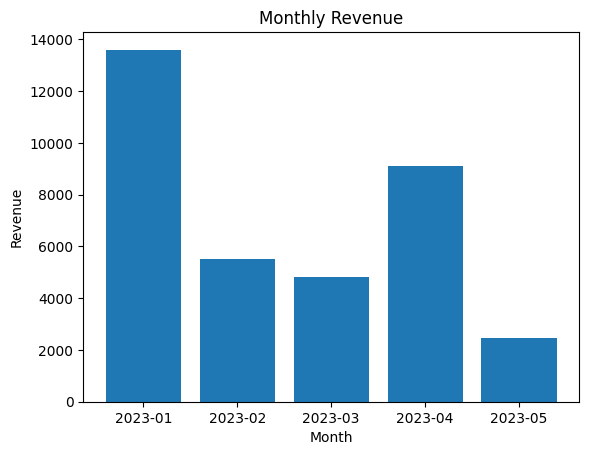

Total Revenue: 35490.0
Product with max revenue: P002
Date with max revenue: 2023-05-25


In [7]:
# Sample Generated Python Code ( Generated with Amazon Bedrock in previous step)

import csv
from collections import defaultdict
import matplotlib.pyplot as plt

revenue = 0
monthly_revenue = defaultdict(int)
product_revenue = defaultdict(int)
max_revenue = 0
max_revenue_date = ''
max_revenue_product = ''

with open('sales.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        date = row[0]
        product = row[1]
        price = float(row[2])
        units = int(row[3])

        revenue += price * units
        product_revenue[product] += price * units
        monthly_revenue[date[:7]] += price * units

        if revenue > max_revenue:
            max_revenue = revenue
            max_revenue_date = date
            max_revenue_product = product

months = list(monthly_revenue.keys())
values = list(monthly_revenue.values())

plt.bar(months, values)
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.title('Monthly Revenue')
plt.show()

print('Total Revenue:', revenue)
print('Product with max revenue:', max_revenue_product)
print('Date with max revenue:', max_revenue_date)

Total revenue: 35490.0
Product with max revenue: P003
Date with max revenue: 2023-04-23


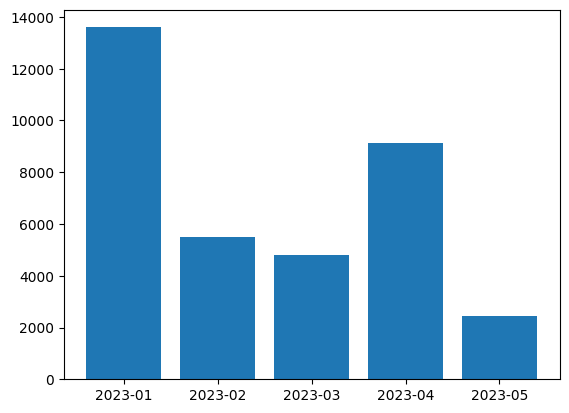

In [9]:
import csv
from collections import defaultdict
import matplotlib.pyplot as plt

revenue_by_month = defaultdict(int)
total_revenue = 0
max_revenue_product = None 
max_revenue = 0
max_revenue_date = None

with open('sales.csv') as f:
  reader = csv.reader(f)
  next(reader) # skip header row

  for row in reader:
    date, product, price, units = row
    revenue = float(price) * int(units)

    total_revenue += revenue

    month = date[:7]
    revenue_by_month[month] += revenue

    if revenue > max_revenue:
      max_revenue = revenue
      max_revenue_product = product
      max_revenue_date = date

print(f"Total revenue: {total_revenue}")
print(f"Product with max revenue: {max_revenue_product}") 
print(f"Date with max revenue: {max_revenue_date}")

plt.bar(revenue_by_month.keys(), revenue_by_month.values())
plt.show()

___

## Introduction

In this section we show you how to use a LLM to generate SQL Query to analyze Sales data.

We will use Bedrock's Claude V2 model using the Boto3 API. 

The prompt used in this example is called a zero-shot prompt because we are not providing any examples of text other than the prompt.

**Note:** *This notebook can be run within or outside of AWS environment.*

#### Context
To demonstrate the SQL code generation capability of Amazon Bedrock, we will explore the use of Boto3 client to communicate with Amazon Bedrock API. We will demonstrate different configurations available as well as how simple input can lead to desired outputs.

#### Pattern
We will simply provide the Amazon Bedrock API with an input consisting of a task, an instruction and an input for the model under the hood to generate an output without providing any additional example. The purpose here is to demonstrate how the powerful LLMs easily understand the task at hand and generate compelling outputs.

#### Use case
Let's take the use case to generate SQL queries to analyze sales data, focusing on trends, top products and average sales.

#### Persona
Maya is a business analyst, at AnyCompany primarily focusing on sales and inventory data. She is transitioning from Speadsheet analysis to data-driven analysis and want to use SQL to fetch specific data points effectively. She wants to use LLMs to generate SQL queries for her analysis. 

#### Implementation
To fulfill this use case, in this notebook we will show how to generate SQL queries. We will use the Anthropic Claude v2 model using the Amazon Bedrock API with Boto3 client. 

## Generate SQL Query

Following on the use case explained above, let's prepare an input for  the Amazon Bedrock service to generate SQL query.

In [10]:
# create the prompt to generate SQL query
prompt_data = """

Human: AnyCompany has a database with a table named sales_data containing sales records. The table has following columns:
- date (YYYY-MM-DD)
- product_id
- price
- units_sold

Can you generate SQL queries for the below: 
- Identify the top 5 best selling products by total sales for the year 2023
- Calculate the monthly average sales for the year 2023

Assistant:
"""


Let's start by using the Anthorpic Claude v2 model. 

In [11]:
# Claude - Body Syntex
body = json.dumps({
                    "prompt": prompt_data,
                    "max_tokens_to_sample":4096,
                    "temperature":0.5,
                    "top_k":250,
                    "top_p":0.5,
                    "stop_sequences": ["\n\nHuman:"]
                  }) 

In [12]:
modelId = 'anthropic.claude-v2' # change this to use a different version from the model provider
accept = 'application/json'
contentType = 'application/json'

response = boto3_bedrock.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
response_body = json.loads(response.get('body').read())

print(response_body.get('completion'))

 Here are the SQL queries to answer the questions:

1. Identify the top 5 best selling products by total sales for the year 2023:

```sql
SELECT product_id, SUM(price * units_sold) AS total_sales
FROM sales_data
WHERE date BETWEEN '2023-01-01' AND '2023-12-31'
GROUP BY product_id
ORDER BY total_sales DESC
LIMIT 5;
```

2. Calculate the monthly average sales for the year 2023:

```sql 
SELECT 
  DATE_FORMAT(date, '%Y-%m') AS month,
  AVG(price * units_sold) AS avg_monthly_sales
FROM sales_data
WHERE date BETWEEN '2023-01-01' AND '2023-12-31'  
GROUP BY month
ORDER BY month;
```

The first query groups the sales data by product_id and sums the total sales for each product in 2023. It then orders by the total_sales column descending and limits to the top 5 results. 

The second query extracts the month from the date column, groups the data by month, calculates the average monthly sales using AVG() and orders the results chronologically.


## Conclusion
You have now experimented with using `boto3` SDK which provides a vanilla exposure to Amazon Bedrock API. Using this API you generate a python program to analyze and visualize given sales data, and generate SQL statements based on an input task and schema.

### Take aways
- Adapt this notebook to experiment with different models available through Amazon Bedrock such as Amazon Titan and AI21 Labs Jurassic models.
